# Dealing with Imbalanced Data via a Pipeline

## Big Question: Which technique, SMOTE or weighted classes, best help estimators predict the minority class when dealing with imbalanced stroke data?

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Preprocessing
import category_encoders
import imblearn.pipeline    

from   sklearn.compose         import *
from   sklearn.impute          import *
from   sklearn.metrics         import *
from   sklearn.model_selection import train_test_split, RandomizedSearchCV
from   sklearn.pipeline        import Pipeline
from   sklearn.preprocessing   import *
from   imblearn.over_sampling  import SMOTE

# Estimators
from sklearn.base              import BaseEstimator
from sklearn.ensemble          import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier

# Graphics
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10.0, 10.0) 
                              ###(  → ,  ↑  ) ###
mpl.rcParams['font.size'] = 24
from sklearn import set_config
set_config(display='diagram')

# Load and Examine Data

In [2]:
df = pd.read_csv("stroke.csv")
X, y = df.drop('stroke', axis=1), df.stroke

In [3]:
X.shape

(5110, 11)

In [4]:
X.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


In [5]:
# for confirming our results
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)

# create dummy estimator to allow random search on a few models
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

# Data Preprocessing

## How columns should be treated: Create 3 categories - Drop, Categorial, Continuous

In [6]:
# choose which type each column is
dropping = ["id"]

continuous_columns = ["age", 
                      "avg_glucose_level", 
                      "bmi"]

categorical_columns = ["gender",
                       "hypertension",
                       "heart_disease",
                       "ever_married", 
                       "work_type", 
                       "Residence_type",
                       "smoking_status"]

# create mini pipelines for continuous and categorical columns
cat_pipe = Pipeline([('freq_imputer', SimpleImputer(strategy='most_frequent')), # deal with missing values
                     ('ohe', OneHotEncoder(handle_unknown="ignore"))]) # deal with categories

cont_pipe = Pipeline([("impute", KNNImputer(n_neighbors=7)), # deal with missing values
                      ("scaler", StandardScaler())]) # standardize

columns_transformed = ColumnTransformer([
                                         ("continuous",  cont_pipe, continuous_columns),
                                         ("categorical", cat_pipe,  categorical_columns)
                                        ],
                                         remainder='drop'
                                        )

## Primary pipeline for testing various models

In [7]:
# For main pipeline
column_treatment = ("columns", columns_transformed)
estimator = ("estimator", DummyEstimator()) # the chosen string must match the search space string: i.e., estimator__

# Main pipeline
pipe = Pipeline([column_treatment, 
                 estimator])

## Choose several estimators and corresponding hyperparameters to test

In [8]:
# define estimators and hyperparameters for testing
lr = dict(estimator=[LogisticRegression(n_jobs=-1)],
                     estimator__C=[0.01, 0.5, 1, 2, 3, 10, 100],
                     estimator__class_weight=[{0:1,1:15}, 
                                              {0:1,1:10}, 
                                             ],
                     estimator__multi_class=["ovr", "multinomial"]
         )

rf = dict(estimator=[RandomForestClassifier(n_jobs=-1)],
                     estimator__criterion=['gini', 'entropy'],
                     estimator__class_weight=['balanced', 'balanced_subsample',
                                             {0:1,1:15}, 
                                              {0:1,1:10}, 
                                              {0:1,1:5}
                                             ],
                     estimator__max_features=[1, 2, 3, 4, "sqrt"],
                     estimator__n_estimators=[100, 150, 200],
                     estimator__min_samples_leaf=[5, 10, 20],
         )

kn = dict(estimator=[KNeighborsClassifier(n_jobs=-1)],
                     estimator__n_neighbors=[1,2,3,4,5],
                     estimator__leaf_size=[10, 20, 30, 40, 50],
                     estimator__weights = ["uniform", "distance"]
         )

# create search space on logistic regression, ensemblers, kneighbors
search_space = [lr, rf, kn]

# random grid search across models and their hyperparms
clf_rand = RandomizedSearchCV(estimator=pipe, 
                              param_distributions=search_space, 
                              n_iter=50,
                              cv=3,
                              verbose=True,
                              scoring='recall'
                              )

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=777)

%time best_model = clf_rand.fit(X_train, y_train)
best_model.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 2min 23s, sys: 7.15 s, total: 2min 30s
Wall time: 27.4 s


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   27.3s finished


{'estimator__multi_class': 'multinomial',
 'estimator__class_weight': {0: 1, 1: 15},
 'estimator__C': 3,
 'estimator': LogisticRegression(C=3, class_weight={0: 1, 1: 15}, multi_class='multinomial',
                    n_jobs=-1)}

In [9]:
best_model.best_estimator_

Pipeline(steps=[('columns',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer(n_neighbors=7)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('freq_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married', 'work_type',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('estimator',
                 LogisticRegression(C=3, class_weight={0: 1, 1: 15},
                                    multi_class='multinomial', n_jobs=-1))])

In [10]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)
y_proba[:5]

array([[0.78871006, 0.21128994],
       [0.95920938, 0.04079062],
       [0.88392172, 0.11607828],
       [0.86399655, 0.13600345],
       [0.76445116, 0.23554884]])

In [11]:
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
acc = balanced_accuracy_score(y_test, y_pred)
cf = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print("recall:", round(recall, 2))
print("precision:", round(precision, 2))
print("f1:", round(f1, 2))
print("balanced_accuracy:", round(acc, 2))
cf

recall: 0.69
precision: 0.17
f1: 0.84
balanced_accuracy: 0.74


array([[1152,  296],
       [  26,   59]])

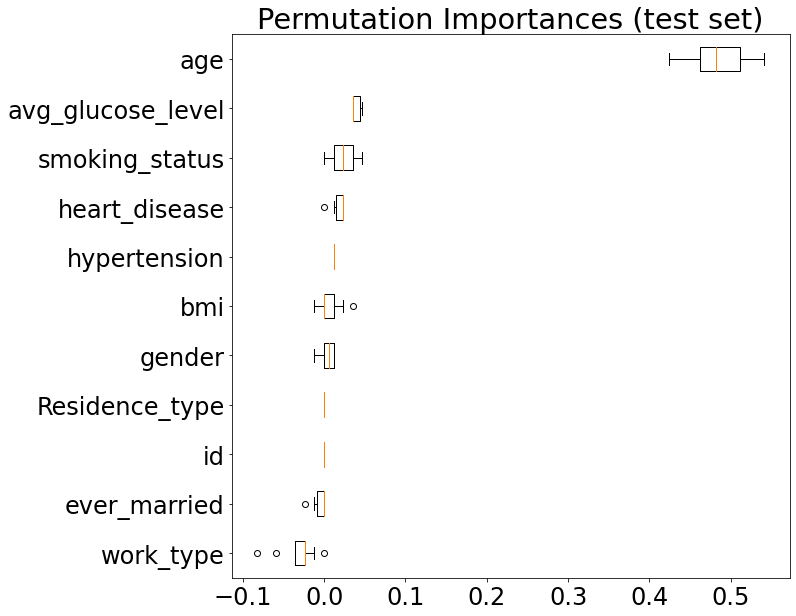

In [12]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
plt.show()

# Implementing with SMOTE

In [13]:
# For main pipeline
smote = ("smote", SMOTE())

# Main pipeline
pipe = imblearn.pipeline.Pipeline([column_treatment, 
                                   smote,
                                   estimator])

In [20]:
# new for smote
sampling_strategy = [.10, .25, .50, .75, 1]
k_neighbors = [1, 2, 3, 4, 5]

# define estimators and hyperparameters for testing
lr = dict(smote__sampling_strategy=sampling_strategy, # only these 2 lines are added to each estimator
          smote__k_neighbors=k_neighbors, # only these 2 lines are added to each estimator
          estimator=[LogisticRegression(n_jobs=-1)],
                     estimator__C=[0.01, 0.5, 1, 2, 3, 10, 100],
                     estimator__class_weight=[{0:1,1:15}, 
                                              {0:1,1:10}, 
                                             ],
                     estimator__multi_class=["ovr", "multinomial"]
         )

rf = dict(smote__sampling_strategy=sampling_strategy,
          smote__k_neighbors=k_neighbors,
          estimator=[RandomForestClassifier(n_jobs=-1)],
                     estimator__criterion=['gini', 'entropy'],
                     estimator__class_weight=['balanced', 'balanced_subsample',
                                             {0:1,1:15}, 
                                              {0:1,1:10}, 
                                              {0:1,1:5}
                                             ],
                     estimator__max_features=[1, 2, 3, 4, "sqrt"],
                     estimator__n_estimators=[100, 150, 200],
                     estimator__min_samples_leaf=[5, 10, 20],
         )

kn = dict(smote__sampling_strategy=sampling_strategy,
          smote__k_neighbors=k_neighbors,
          estimator=[KNeighborsClassifier(n_jobs=-1)],
                     estimator__n_neighbors=[1,2,3,4,5],
                     estimator__leaf_size=[10, 20, 30, 40, 50],
                     estimator__weights = ["uniform", "distance"]
         )

# create search space on logistic regression, ensemblers, kneighbors
search_space = [lr, rf, kn]

# random grid search across models and their hyperparms
clf_rand = RandomizedSearchCV(estimator=pipe, 
                              param_distributions=search_space, 
                              n_iter=50,
                              cv=3,
                              verbose=True,
                              scoring='recall'
                              )

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=777)

%time best_model = clf_rand.fit(X_train, y_train)
best_model.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   31.9s finished


CPU times: user 2min 39s, sys: 8.08 s, total: 2min 47s
Wall time: 32.2 s


{'smote__sampling_strategy': 0.25,
 'smote__k_neighbors': 1,
 'estimator__n_estimators': 200,
 'estimator__min_samples_leaf': 20,
 'estimator__max_features': 1,
 'estimator__criterion': 'gini',
 'estimator__class_weight': {0: 1, 1: 15},
 'estimator': RandomForestClassifier(class_weight={0: 1, 1: 15}, max_features=1,
                        min_samples_leaf=20, n_estimators=200, n_jobs=-1)}

In [21]:
best_model.best_estimator_

Pipeline(steps=[('columns',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer(n_neighbors=7)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('freq_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married', 'work_type',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('smote', SMOTE(k_neighbors=1, sampling_strategy=0.25)),
                ('estimator',
                 RandomForestClassifier(class_weight={0: 1, 1: 15},
                                        max_features=1, min_samples_leaf=20,
                                        n_estimators=200, n_jobs=-1))])

In [22]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)
y_proba[:5]

array([[0.34300152, 0.65699848],
       [0.55324653, 0.44675347],
       [0.47925755, 0.52074245],
       [0.32754428, 0.67245572],
       [0.28607608, 0.71392392]])

In [23]:
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
acc = balanced_accuracy_score(y_test, y_pred)
cf = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print("recall:", round(recall, 2))
print("precision:", round(precision, 2))
print("f1:", round(f1, 2))
print("balanced_accuracy:", round(acc, 2))
cf

recall: 1.0
precision: 0.08
f1: 0.44
balanced_accuracy: 0.65


array([[ 433, 1015],
       [   0,   85]])

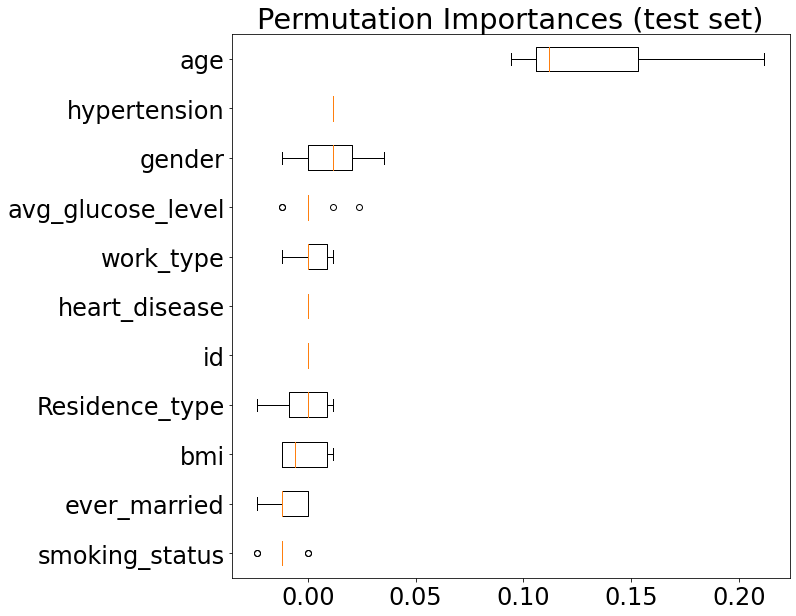

In [18]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
plt.show()

# Conclusion

## Best final model for recall (visual above)
SMOTE(sampling_strategy=1, k_neighbors =1)

RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 10},
                        max_features=1, min_samples_leaf=20, n_estimators=150,
                        n_jobs=-1)

Under similar conditions, SMOTE was able to get a much higher recall on unseen data. 
This may be particularly important if doctors wish to reduce the number of those who pass away
from a stroke and can accept a high number of false positives. If such a high number is not 
acceptable, then a non-SMOTE model may be better for business.

## Future Directions
The present experiment used a single train and test set, but future work should create several
train and test sets to truly compare which is better. As well, more (hyper)parameters may be added
into the model or a more exhaustive technique such as GridSearch may yield better results.